In [93]:
%matplotlib inline

import sys
sys.path.append("../../ee595")
from deepsea import *

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import binarize
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import scipy as sp
import scipy.io as sio

import h5py

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from keras.models import load_model

sys.path.append("../../IntegratedGradients")
from IntegratedGradients import integrated_gradients

In [109]:
def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [116]:
def load_result(files):
    labels = ["acc", "loss", "val_loss", "val_acc"]
    ret = {"acc":[], "loss":[], "val_loss":[], "val_acc":[],}
    for path in files:
        result = load_obj(path)
        for l in labels:
            ret[l] = ret[l] + result[l]
    return ret

# Building the machine learning model

ATACPeak is basically deepsea with ATAC-seq information.
Deepsea is basically deepsea except that you only have 1 output.

In [2]:
def ATACPeak():
    nkernels = [320,480,960]
    in_size = (1,1000,5)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

In [115]:
def DeepSEA():
    nkernels = [320,480,960]
    in_size = (1,1000,4)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

# Loading the data

Preprocessing the data set and saving it to the dat direcotry.

In [7]:
# data loading

test_X, test_Y = loaddata("../../ee595/data/deepsea/", "test")
train_X, train_Y = loaddata("../../ee595/data/deepsea/", "train")
valid_X, valid_Y = loaddata("../../ee595/data/deepsea/", "valid")

In [39]:
# data loading

train_atac = np.load("atactrain.npy")
test_atac = np.load("atactest.npy")
valid_atac = np.load("atacvalid.npy")

In [40]:
train_atac = np.expand_dims(train_atac, 1)
test_atac = np.expand_dims(test_atac, 1)
valid_atac = np.expand_dims(valid_atac, 1)

In [29]:
# index

trainindex = np.load("trainindex.npy")
testindex = np.load("testindex.npy")
validindex = np.load("validindex.npy")

In [28]:
# generating index

data = valid_Y
positives = [i for i in range(data.shape[0]) if data[i, 2] == 1]
negatives = [i for i in range(data.shape[0]) if data[i, 2] == 0]
np.random.shuffle(negatives)
index = positives+negatives[:len(positives)]
index = sorted(index)
np.save("validindex", index)

In [41]:
train_X = train_X[trainindex]
test_X = test_X[testindex]
valid_X = valid_X[validindex]

In [45]:
train_Y = train_Y[trainindex][:,2]
test_Y = test_Y[testindex][:,2]
valid_Y = valid_Y[validindex][:,2]

In [49]:
train_atac = np.concatenate([train_atac, train_atac], axis=0)[trainindex]
test_atac = np.concatenate([test_atac, test_atac], axis=0)[testindex]
valid_atac = np.concatenate([valid_atac, valid_atac], axis=0)[validindex]

In [58]:
valid_X2 = np.concatenate([valid_X, valid_atac], axis=3)
test_X2 = np.concatenate([test_X, test_atac], axis=3)
train_X2 = np.concatenate([train_X, train_atac], axis=3)

In [62]:
np.save("trainx", train_X2)
np.save("testx", test_X2)
np.save("validx", valid_X2)

In [63]:
np.save("trainy", train_Y)
np.save("testy", test_Y)
np.save("validy", valid_Y)

# Training starts

Deepsea and atacpeak are both trained on the same dataset.

In [64]:
model = ATACPeak()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-full.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [112]:
result = model.fit(train_X2, train_Y,
          epochs=20, 
          batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=5, 
          validation_data=(valid_X2, valid_Y),
          verbose=0)

Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.47596 to 0.46885, saving model to weights-improvement-06-0.47-full.hdf5
Epoch 00007: val_loss improved from 0.46885 to 0.46479, saving model to weights-improvement-07-0.46-full.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not improve


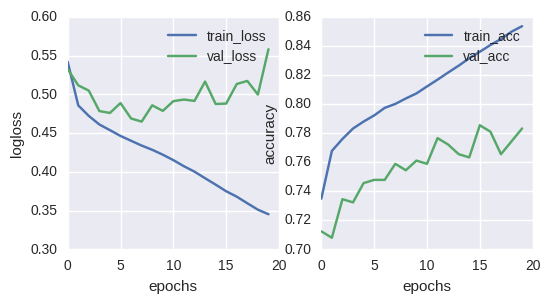

In [150]:
# learning path
result = load_result(["model/atacpeak_history.pkl", "model/atacpeak_history2.pkl"])

plt.figure(figsize=(6,3))
plt.subplot("121")
plt.plot(range(len(result["loss"])), result["loss"], label="train_loss")
plt.plot(range(len(result["val_loss"])), result["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.legend()

plt.subplot("122")
plt.plot(range(len(result["acc"])), result["acc"], label="train_acc")
plt.plot(range(len(result["val_acc"])), result["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Training deepsea on the same condition

In [120]:
model = DeepSEA()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [121]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-deepsea.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [122]:
result = model.fit(train_X, train_Y,
          epochs=20, 
          batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=5, 
          validation_data=(valid_X, valid_Y),
          verbose=0)

Epoch 00005: val_loss improved from inf to 8.05984, saving model to weights-improvement-05-8.06-full.hdf5
Epoch 00006: val_loss improved from 8.05984 to 8.05933, saving model to weights-improvement-06-8.06-full.hdf5
Epoch 00007: val_loss improved from 8.05933 to 8.05914, saving model to weights-improvement-07-8.06-full.hdf5
Epoch 00008: val_loss improved from 8.05914 to 0.57834, saving model to weights-improvement-08-0.58-full.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.57834 to 0.52783, saving model to weights-improvement-10-0.53-full.hdf5
Epoch 00011: val_loss improved from 0.52783 to 0.52225, saving model to weights-improvement-11-0.52-full.hdf5
Epoch 00012: val_loss improved from 0.52225 to 0.51816, saving model to weights-improvement-12-0.52-full.hdf5
Epoch 00013: val_loss improved from 0.51816 to 0.50182, saving model to weights-improvement-13-0.50-full.hdf5
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss improved from 0.50182 to 0

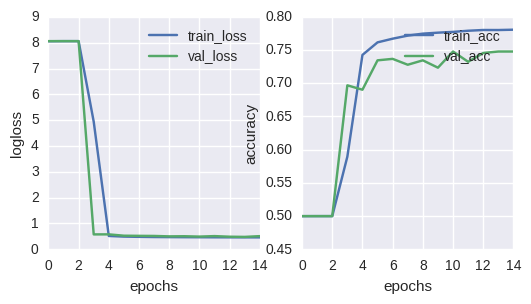

In [151]:
# learning path
result = load_result(["model/deepsea_history.pkl"])

plt.figure(figsize=(6,3))
plt.subplot("121")
plt.plot(range(len(result["loss"])), result["loss"], label="train_loss")
plt.plot(range(len(result["val_loss"])), result["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.legend()

plt.subplot("122")
plt.plot(range(len(result["acc"])), result["acc"], label="train_acc")
plt.plot(range(len(result["val_acc"])), result["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Comparing the minimum trainig loss for both models

In [165]:
result = load_result(["model/deepsea_history.pkl"])
print "DEEPSEA (training loss):", np.min(result["loss"]), str(np.argmin(result["loss"]))+ "th epoch"

result = load_result(["model/atacpeak_history.pkl", "model/atacpeak_history2.pkl"])
print "ATACPEAK (training loss):", np.min(result["loss"]), str(np.argmin(result["loss"]))+ "th epoch"

DEEPSEA (training loss): 0.462422104664 14th epoch
ATACPEAK (training loss): 0.34529576431 19th epoch


# ROC curve

Comparing area under ROC curve generated from the test set for deepsea and atacpeak trained on the same model.

atacpeak

In [136]:
model1 = load_model("model/atacpeak-07.hdf5")

In [137]:
# make a prediction
prediction = model1.predict(test_X2)

In [138]:
fpr, tpr, _ = roc_curve(test_Y, prediction)

0.878457196414


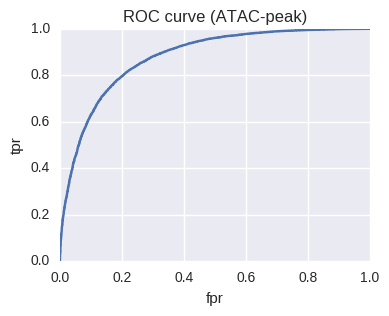

In [139]:
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve (ATAC-peak)")
print roc_auc_score(test_Y, prediction)

deepsea

In [141]:
model2 = load_model("model/deepsea-18.hdf5")

In [142]:
prediction2 = model2.predict(test_X)

0.866682905814


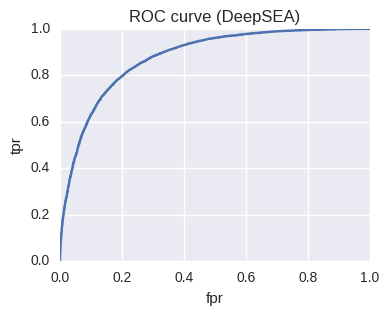

In [144]:
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve (DeepSEA)")
print roc_auc_score(test_Y, prediction2)

# Explaining

Integrated gradients explanation of deepsea and ATACpeak models.

In [166]:
index = [i for i in range(len(test_Y)) if test_Y[i] == 1 and prediction[i] > 0.95]

In [167]:
ig = integrated_gradients(model1, verbose=0)

([], <a list of 0 Text xticklabel objects>)

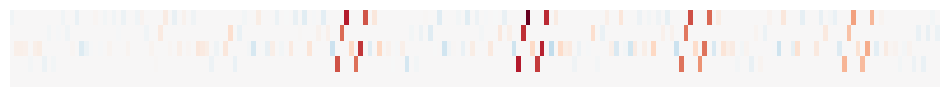

In [168]:
ex = ig.explain(test_X2[index[1]])[0][400:600]
plt.figure(figsize=(12,1))
sns.heatmap(np.transpose(ex), cbar=False)
plt.yticks([],[])
plt.xticks([],[])

([], <a list of 0 Text xticklabel objects>)

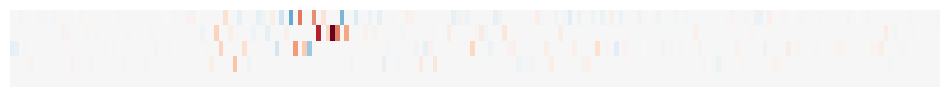

In [169]:
ex = ig.explain(test_X2[index[100]])[0][400:600]
plt.figure(figsize=(12,1))
sns.heatmap(np.transpose(ex), cbar=False)
plt.yticks([],[])
plt.xticks([],[])

([], <a list of 0 Text xticklabel objects>)

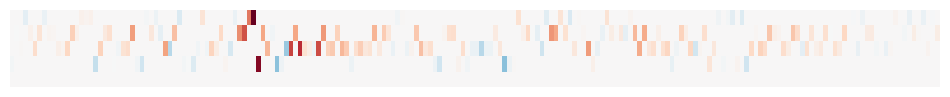

In [170]:
ex = ig.explain(test_X2[index[150]])[0][400:600]
plt.figure(figsize=(12,1))
sns.heatmap(np.transpose(ex), cbar=False)
plt.yticks([],[])
plt.xticks([],[])